(bayes_param_survival)=

# Bayesian Parametric Survival Analysis

In [1]:
import warnings

import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import scipy as sp
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from statsmodels import datasets

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
warnings.filterwarnings("ignore")

[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) studies the distribution of the time between when a subject comes under observation and when that subject experiences an event of interest.  One of the fundamental challenges of survival analysis (which also makes is mathematically interesting) is that, in general, not every subject will experience the event of interest before we conduct our analysis.  In more concrete terms, if we are studying the time between cancer treatment and death (as we will in this post), we will often want to analyze our data before every subject has died.  This phenomenon is called [censoring](https://en.wikipedia.org/wiki/Censoring_(statistics)) and is fundamental to survival analysis.


This post illustrates a parametric approach to Bayesian survival analysis in PyMC. Parametric models of survival are simpler to both implement and understand than semiparametric models; statistically, they are also more [powerful](https://en.wikipedia.org/wiki/Power_(statistics)) than non- or semiparametric methods when they are correctly specified. For an example of a [semiparametric](https://en.wikipedia.org/wiki/Semiparametric_model) [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model#The_Cox_model), you can read this [blogpost](http://austinrochford.com/posts/2015-10-05-bayes-survival.html), but be aware that the post used and old version of PyMC and that Implementing a semiparametric model in PyMC involved some fairly complex numpy code and nonobvious probability theory equivalences.

We will analyze the [mastectomy data](https://vincentarelbundock.github.io/Rdatasets/doc/HSAUR/mastectomy.html) from `R`'s [`HSAUR`](https://cran.r-project.org/web/packages/HSAUR/index.html) package. 

In [3]:
sns.set()
blue, green, red, purple, gold, teal = sns.color_palette(n_colors=6)

pct_formatter = StrMethodFormatter("{x:.1%}")

In [4]:
df = datasets.get_rdataset("mastectomy", "HSAUR", cache=True).data.assign(
    metastized=lambda df: 1.0 * (df.metastized == "yes"), event=lambda df: 1.0 * df.event
)
df.head()

,time,event,metastized
0,23,1.0,0.0
1,47,1.0,0.0
2,69,1.0,0.0
3,70,0.0,0.0
4,100,0.0,0.0


The column `time` represents the survival time for a breast cancer patient after a mastectomy, measured in months.  The column `event` indicates whether or not the observation is censored.  If `event` is one, the patient's death was observed during the study; if `event` is zero,  the patient lived past the end of the study and their survival time is censored.  The column `metastized` indicates whether the cancer had [metastized](https://en.wikipedia.org/wiki/Metastasis) prior to the mastectomy.  In this post, we will use Bayesian parametric survival regression to quantify the difference in survival times for patients whose cancer had and had not metastized.

## Accelerated failure time models

[Accelerated failure time models](https://en.wikipedia.org/wiki/Accelerated_failure_time_model) are the most common type of parametric survival regression models.  The fundamental quantity of survival analysis is the [survival function](https://en.wikipedia.org/wiki/Survival_function); if $T$ is the random variable representing the time to the event in question, the survival function is $S(t) = P(T > t)$.  Accelerated failure time models incorporate covariates $\mathbf{x}$ into the survival function as

$$S(t\ |\ \beta, \mathbf{x}) = S_0\left(\exp\left(\beta^{\top} \mathbf{x}\right) \cdot t\right),$$

where $S_0(t)$ is a fixed baseline survival function.  These models are called "accelerated failure time" because, when $\beta^{\top} \mathbf{x} > 0$, $\exp\left(\beta^{\top} \mathbf{x}\right) \cdot t > t$, so the effect of the covariates is to accelerate the _effective_ passage of time for the individual in question.  The following plot illustrates this phenomenon using an exponential survival function.

In [5]:
S0 = sp.stats.expon.sf

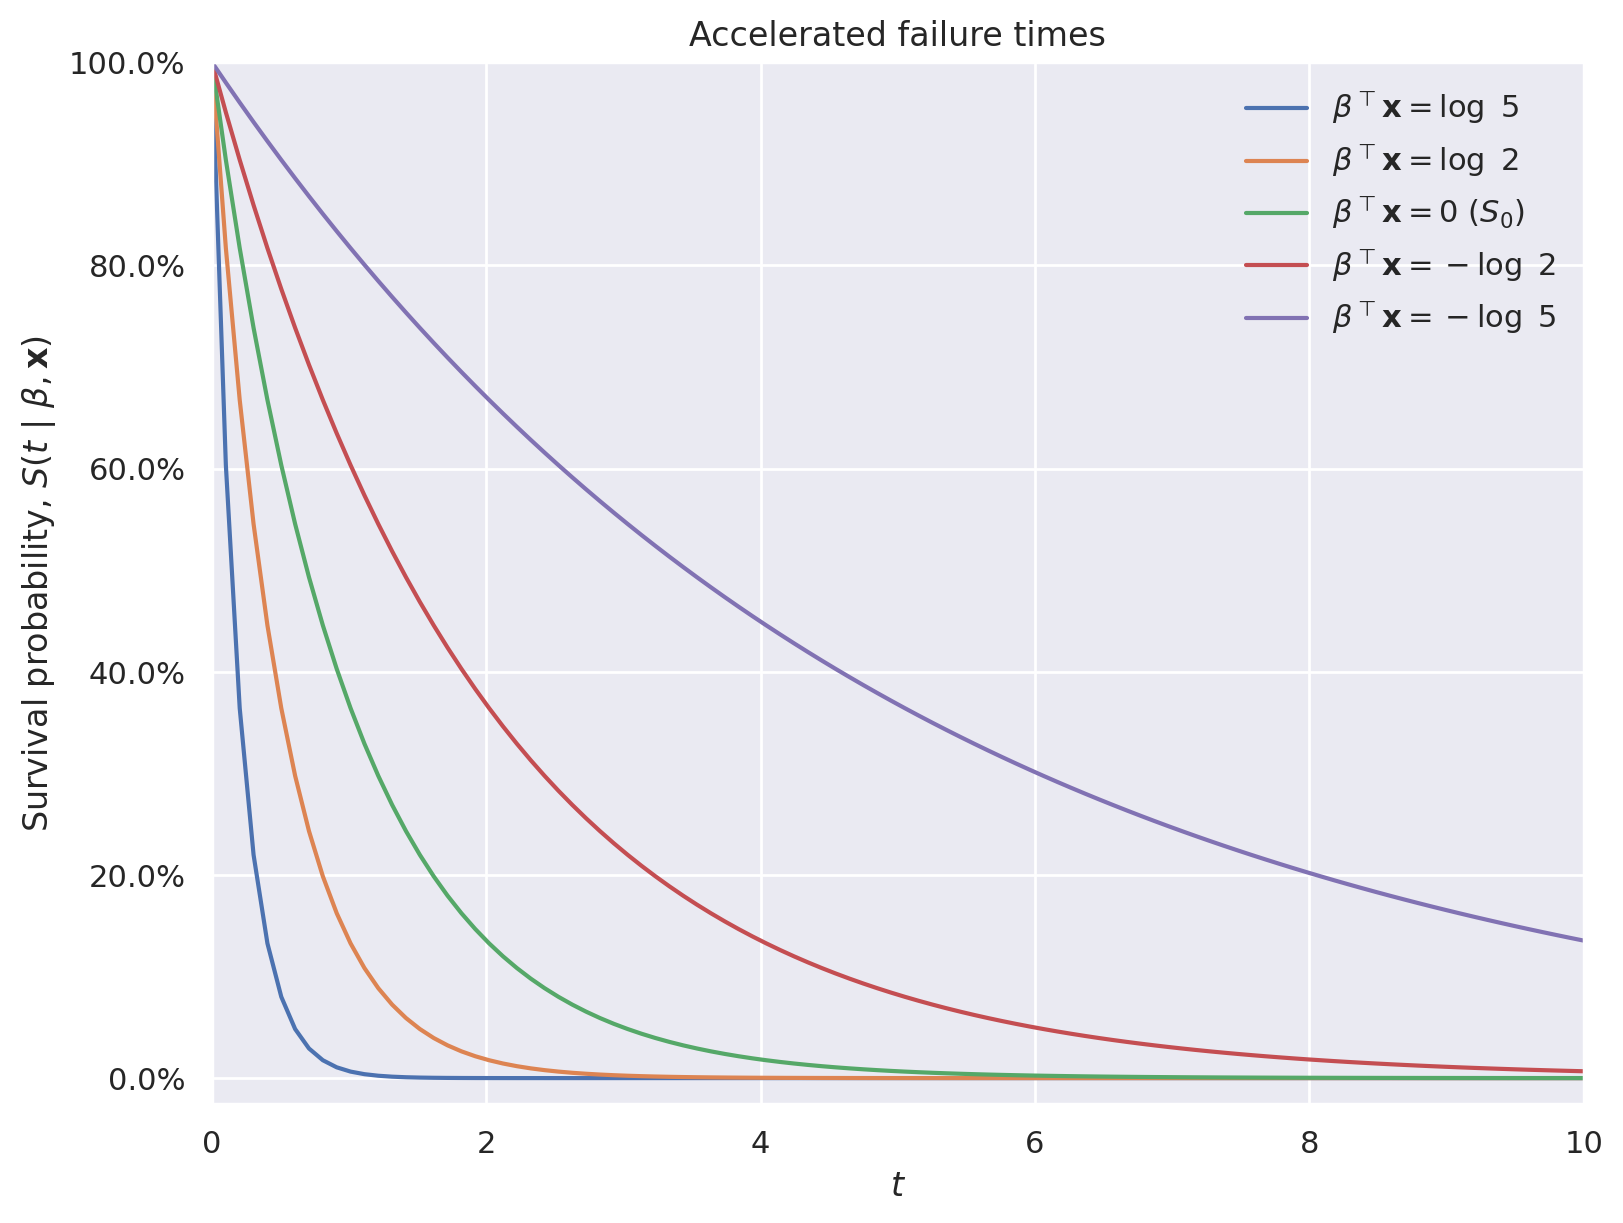

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

t = np.linspace(0, 10, 100)

ax.plot(t, S0(5 * t), label=r"$\beta^{\top} \mathbf{x} = \log\ 5$")
ax.plot(t, S0(2 * t), label=r"$\beta^{\top} \mathbf{x} = \log\ 2$")
ax.plot(t, S0(t), label=r"$\beta^{\top} \mathbf{x} = 0$ ($S_0$)")
ax.plot(t, S0(0.5 * t), label=r"$\beta^{\top} \mathbf{x} = -\log\ 2$")
ax.plot(t, S0(0.2 * t), label=r"$\beta^{\top} \mathbf{x} = -\log\ 5$")

ax.set_xlim(0, 10)
ax.set_xlabel(r"$t$")

ax.yaxis.set_major_formatter(pct_formatter)
ax.set_ylim(-0.025, 1)
ax.set_ylabel(r"Survival probability, $S(t\ |\ \beta, \mathbf{x})$")

ax.legend(loc=1)
ax.set_title("Accelerated failure times");

Accelerated failure time models are equivalent to log-linear models for $T$,

$$Y = \log T = \beta^{\top} \mathbf{x} + \varepsilon.$$

A choice of distribution for the error term $\varepsilon$ determines baseline survival function, $S_0$, of the accelerated failure time model.  The following table shows the correspondence between the distribution of $\varepsilon$ and $S_0$ for several common accelerated failure time models.

| Log-linear error distribution ($\varepsilon$) | Baseline survival function ($S_0$) |
|-----------------------------------------------|-------------------------------------|
| [Normal](https://en.wikipedia.org/wiki/Normal_distribution) | [Log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) |
| Extreme value ([Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution)) | [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution) |
| [Logistic](https://en.wikipedia.org/wiki/Logistic_distribution) | [Log-logistic](https://en.wikipedia.org/wiki/Log-logistic_distribution) |

Accelerated failure time models are conventionally named after their baseline survival function, $S_0$.  The rest of this post will show how to implement Weibull and log-logistic survival regression models in PyMC using the mastectomy data.

### Weibull survival regression

In this example, the covariates are $\mathbf{x}_i = \left(1\ x^{\textrm{met}}_i\right)^{\top}$, where

$$
\begin{align*}
x^{\textrm{met}}_i
    & = \begin{cases}
        0 & \textrm{if the } i\textrm{-th patient's cancer had not metastized} \\
        1 & \textrm{if the } i\textrm{-th patient's cancer had metastized}
    \end{cases}.
\end{align*}
$$

We construct the matrix of covariates $\mathbf{X}$.

In [7]:
n_patient, _ = df.shape

X = np.empty((n_patient, 2))
X[:, 0] = 1.0
X[:, 1] = df.metastized

with pm.Model() as weibull_model:
    predictors = pm.Data("predictors", X)

The likelihood of the data is specified in two parts, one for uncensored samples, and one for censored samples.  Since $Y = \eta + \varepsilon$, and $\varepsilon \sim \textrm{Gumbel}(0, s)$, $Y \sim \textrm{Gumbel}(\eta, s)$.  For the uncensored survival times, the likelihood is implemented as

In [8]:
with weibull_model:
    censored = pm.Data("censored", df.event.values == 0.0)

We transform the observed times to the log scale and standardize them.

In [9]:
y = np.log(df.time.values)
y_std = (y - y.mean()) / y.std()

with weibull_model:
    y_obs = pm.Data("y_obs", y_std[df.event.values == 1.0])
    y_cens = pm.Data("y_cens", y_std[df.event.values == 0.0])

We place independent, vague normal prior distributions on the regression coefficients,

$$\beta \sim N(0, 5^2 I_2).$$

In [10]:
with weibull_model:
    beta = pm.Normal("beta", mu=0.0, sigma=5.0, shape=2)

The covariates, $\mathbf{x}$, affect value of $Y = \log T$ through $\eta = \beta^{\top} \mathbf{x}$.

In [11]:
with weibull_model:
    eta = beta.dot(predictors.T)

For Weibull regression, we use

$$
\begin{align*}
    \varepsilon
        & \sim \textrm{Gumbel}(0, s) \\
    s
        & \sim \textrm{HalfNormal(5)}.
\end{align*}
$$

In [12]:
with weibull_model:
    s = pm.HalfNormal("s", 5.0)

In [13]:
with weibull_model:
    events = pm.Gumbel("events", eta[~censored], s, observed=y_obs)

For censored observations, we only know that their true survival time exceeded the total time that they were under observation.  This probability is given by the survival function of the Gumbel distribution,

$$P(Y \geq y) = 1 - \exp\left(-\exp\left(-\frac{y - \mu}{s}\right)\right).$$

This survival function is implemented below.

In [14]:
def gumbel_sf(y, mu, sigma):
    return 1.0 - pt.exp(-pt.exp(-(y - mu) / sigma))

We now specify the likelihood for the censored observations.

In [15]:
with weibull_model:
    censored_like = pm.Potential("censored_like", gumbel_sf(y_cens, eta[censored], s))

We now sample from the model.

In [16]:
SEED = 845199  # from random.org, for reproducibility

SAMPLE_KWARGS = {"chains": 4, "tune": 1000, "random_seed": [SEED + i for i in range(4)]}

In [17]:
with weibull_model:
    weibull_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, s]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


The energy plot and Bayesian fraction of missing information give no cause for concern about poor mixing in NUTS.

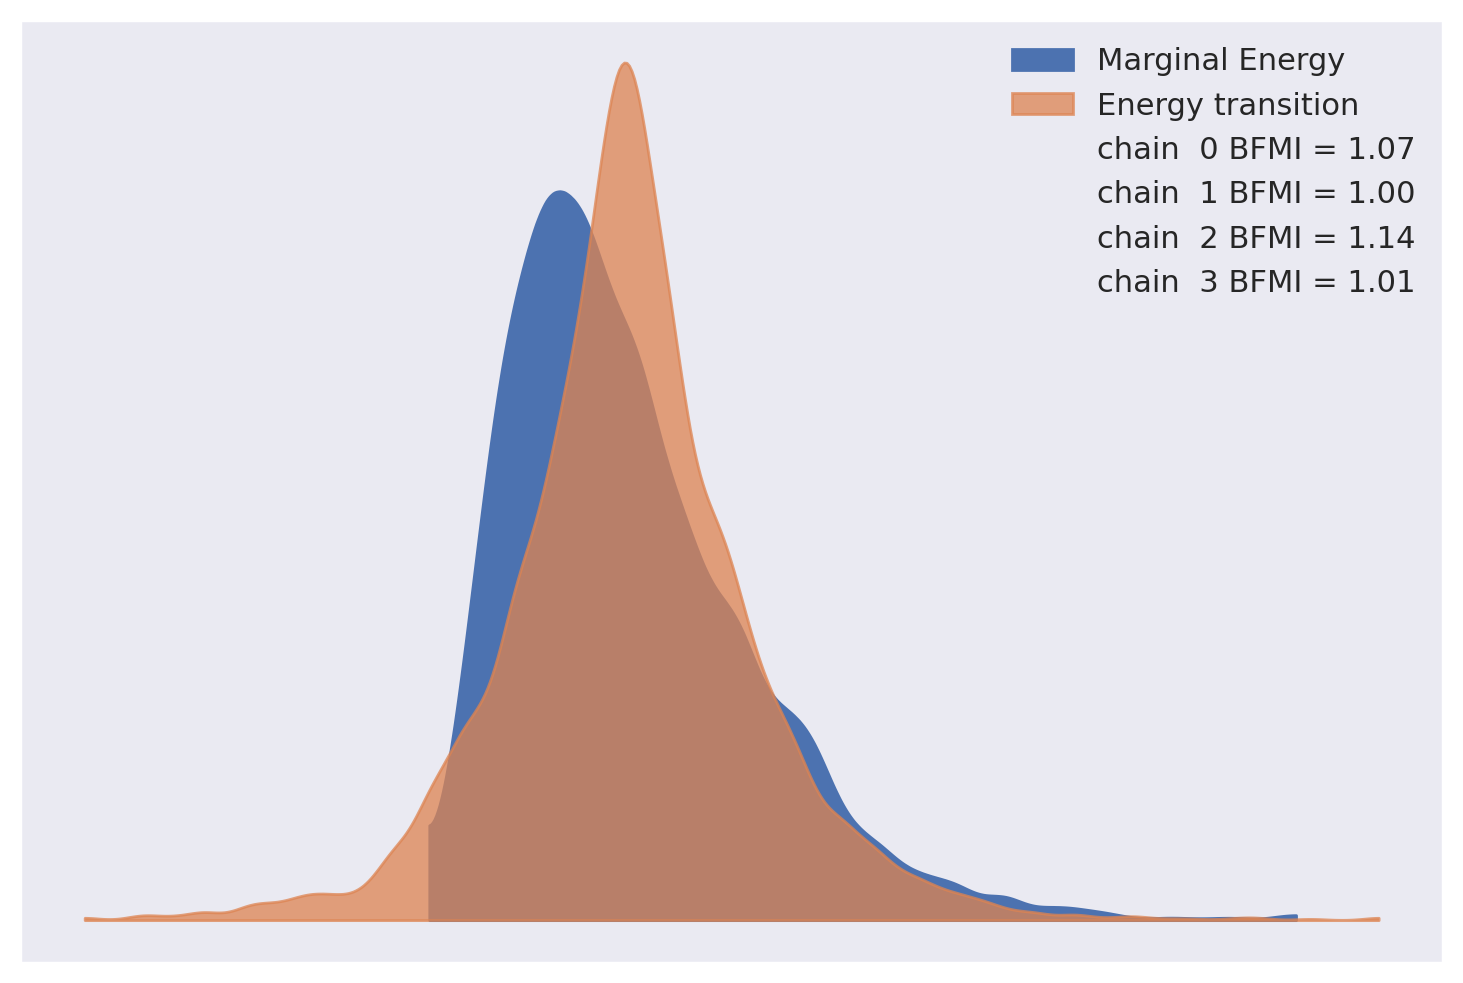

In [18]:
az.plot_energy(weibull_trace, fill_color=("C0", "C1"));

The $\hat{R}$ statistics also indicate convergence.

In [19]:
max(np.max(gr_stats) for gr_stats in az.rhat(weibull_trace).values())

<xarray.DataArray 'beta' ()> Size: 8B
array(1.00442271)

Below we plot posterior distributions of the parameters.

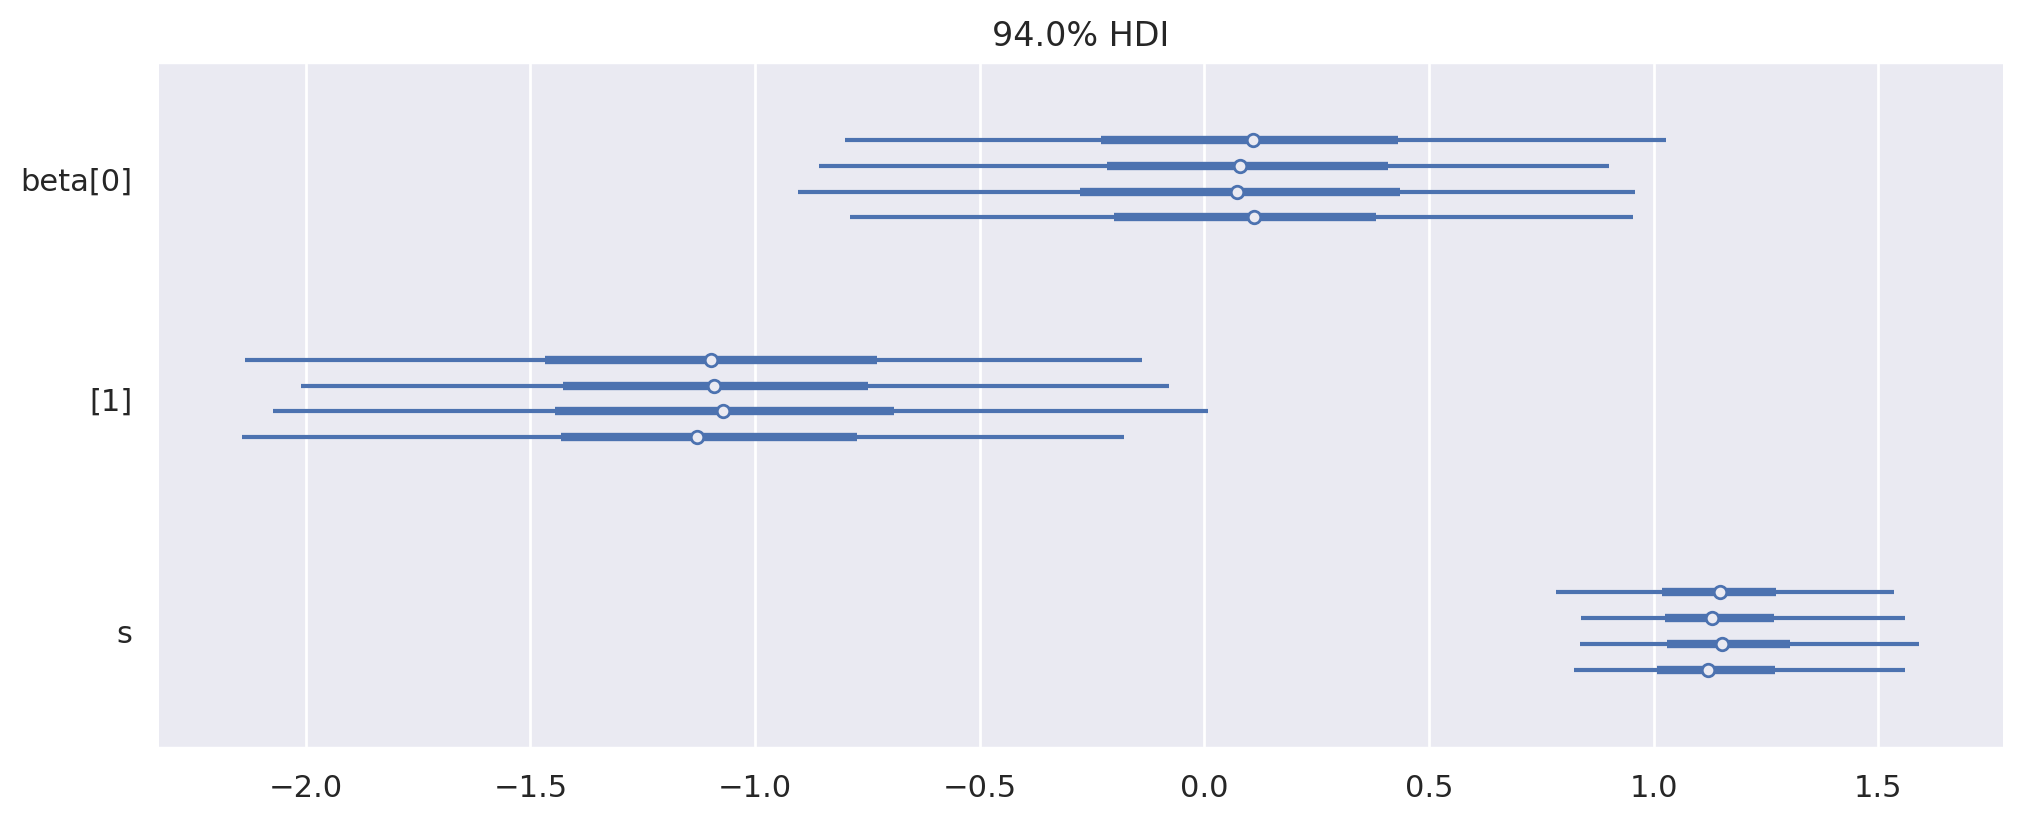

In [20]:
az.plot_forest(weibull_trace, figsize=(10, 4));

These are somewhat interesting (especially the fact that the posterior of $\beta_1$ is fairly well-separated from zero), but the posterior predictive survival curves will be much more interpretable.

The advantage of using `Data` variables is that we can now change their values to perform posterior predictive sampling.  For posterior prediction, we set $X$ to have two rows, one for a subject whose cancer had not metastized and one for a subject whose cancer had metastized.  Since we want to predict actual survival times, none of the posterior predictive rows are censored.

In [21]:
X_pp = np.empty((2, 2))
X_pp[:, 0] = 1.0
X_pp[:, 1] = [0, 1]

cens_pp = np.repeat(False, 2)

with weibull_model:
    pm.set_data(
        {"predictors": X_pp, "censored": cens_pp, "y_obs": np.zeros(2), "y_cens": np.zeros(0)}
    )

In [22]:
with weibull_model:
    pp_weibull_trace = pm.sample_posterior_predictive(weibull_trace)

Sampling: [events]


Output()

The posterior predictive survival times show that, on average, patients whose cancer had not metastized survived longer than those whose cancer had metastized.

In [23]:
t_plot = np.linspace(0, 230, 100)

weibull_pp_surv = np.greater_equal.outer(
    np.exp(
        y.mean()
        + y.std() * az.extract(pp_weibull_trace.posterior_predictive["events"])["events"].values
    ),
    t_plot,
)
weibull_pp_surv_mean = weibull_pp_surv.mean(axis=1)

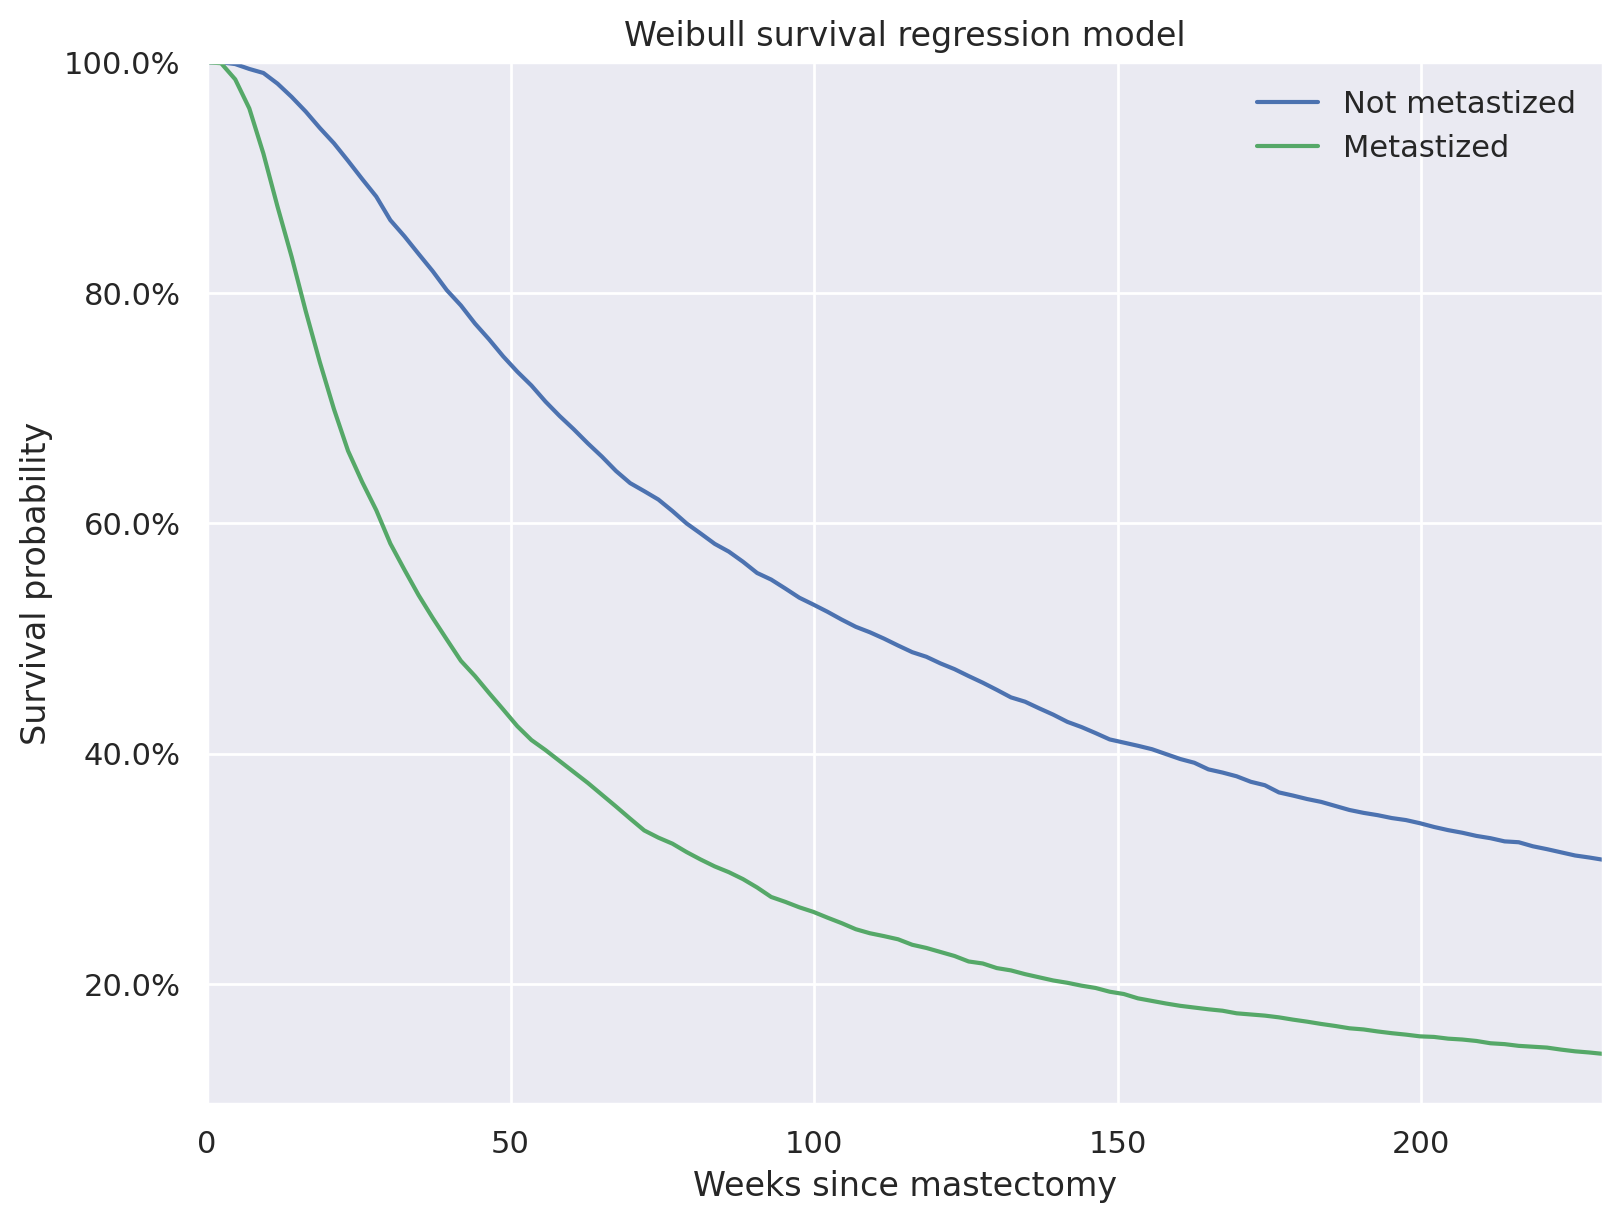

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))


ax.plot(t_plot, weibull_pp_surv_mean[0], c=blue, label="Not metastized")
ax.plot(t_plot, weibull_pp_surv_mean[1], c=red, label="Metastized")

ax.set_xlim(0, 230)
ax.set_xlabel("Weeks since mastectomy")

ax.set_ylim(top=1)
ax.yaxis.set_major_formatter(pct_formatter)
ax.set_ylabel("Survival probability")

ax.legend(loc=1)
ax.set_title("Weibull survival regression model");

### Log-logistic survival regression

Other accelerated failure time models can be specified in a modular way by changing the prior distribution on $\varepsilon$.  A log-logistic model corresponds to a [logistic](https://en.wikipedia.org/wiki/Logistic_distribution) prior on $\varepsilon$.  Most of the model specification is the same as for the Weibull model above.

In [25]:
with pm.Model() as log_logistic_model:
    predictors = pm.Data("predictors", X)
    censored = pm.Data("censored", df.event.values == 0.0)
    y_obs = pm.Data("y_obs", y_std[df.event.values == 1.0])
    y_cens = pm.Data("y_cens", y_std[df.event.values == 0.0])

    beta = pm.Normal("beta", 0.0, 5.0, shape=2)
    eta = beta.dot(predictors.T)

    s = pm.HalfNormal("s", 5.0)

We use the prior $\varepsilon \sim \textrm{Logistic}(0, s)$.  The survival function of the logistic distribution is

$$P(Y \geq y) = 1 - \frac{1}{1 + \exp\left(-\left(\frac{y - \mu}{s}\right)\right)},$$

so we get the likelihood

In [26]:
def logistic_sf(y, mu, s):
    return 1.0 - pm.math.sigmoid((y - mu) / s)

In [27]:
with log_logistic_model:
    events = pm.Logistic("events", eta[~censored], s, observed=y_obs)
    censored_like = pm.Potential("censored_like", logistic_sf(y_cens, eta[censored], s))

We now sample from the log-logistic model.

In [28]:
with log_logistic_model:
    log_logistic_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, s]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


All of the sampling diagnostics look good for this model.

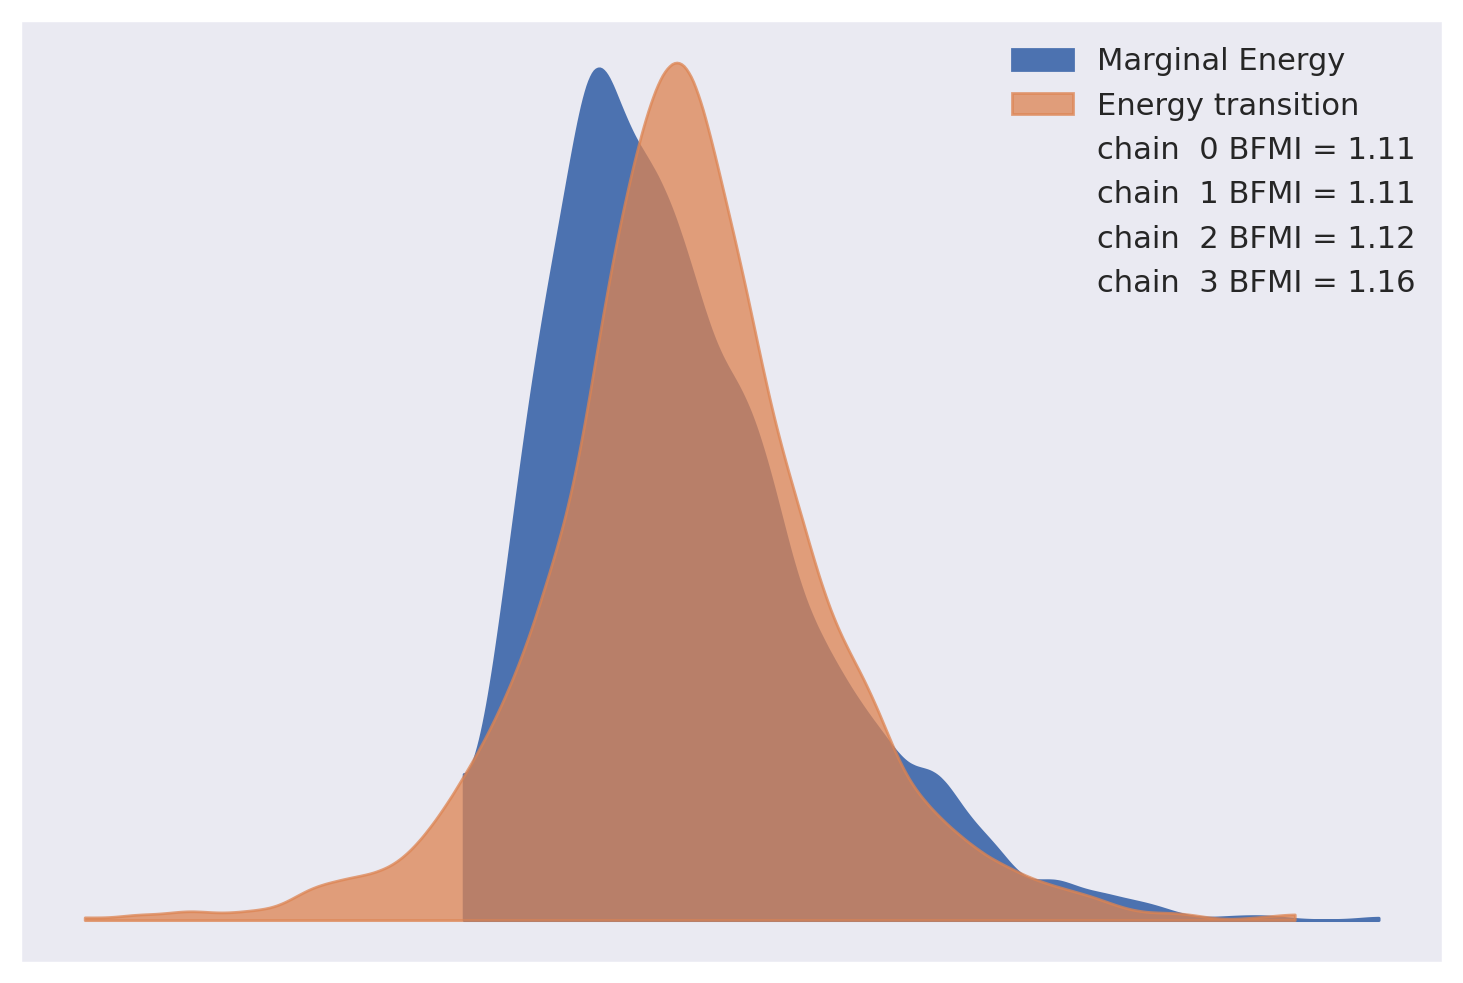

In [29]:
az.plot_energy(log_logistic_trace, fill_color=("C0", "C1"));

In [30]:
max(np.max(gr_stats) for gr_stats in az.rhat(log_logistic_trace).values())

<xarray.DataArray 'beta' ()> Size: 8B
array(1.00301488)

Again, we calculate the posterior expected survival functions for this model.

In [31]:
with log_logistic_model:
    pm.set_data(
        {"predictors": X_pp, "censored": cens_pp, "y_obs": np.zeros(2), "y_cens": np.zeros(0)}
    )
    pp_log_logistic_trace = pm.sample_posterior_predictive(log_logistic_trace)

Sampling: [events]


Output()

In [32]:
log_logistic_pp_surv = np.greater_equal.outer(
    np.exp(
        y.mean()
        + y.std()
        * az.extract(pp_log_logistic_trace.posterior_predictive["events"])["events"].values
    ),
    t_plot,
)
log_logistic_pp_surv_mean = log_logistic_pp_surv.mean(axis=1)

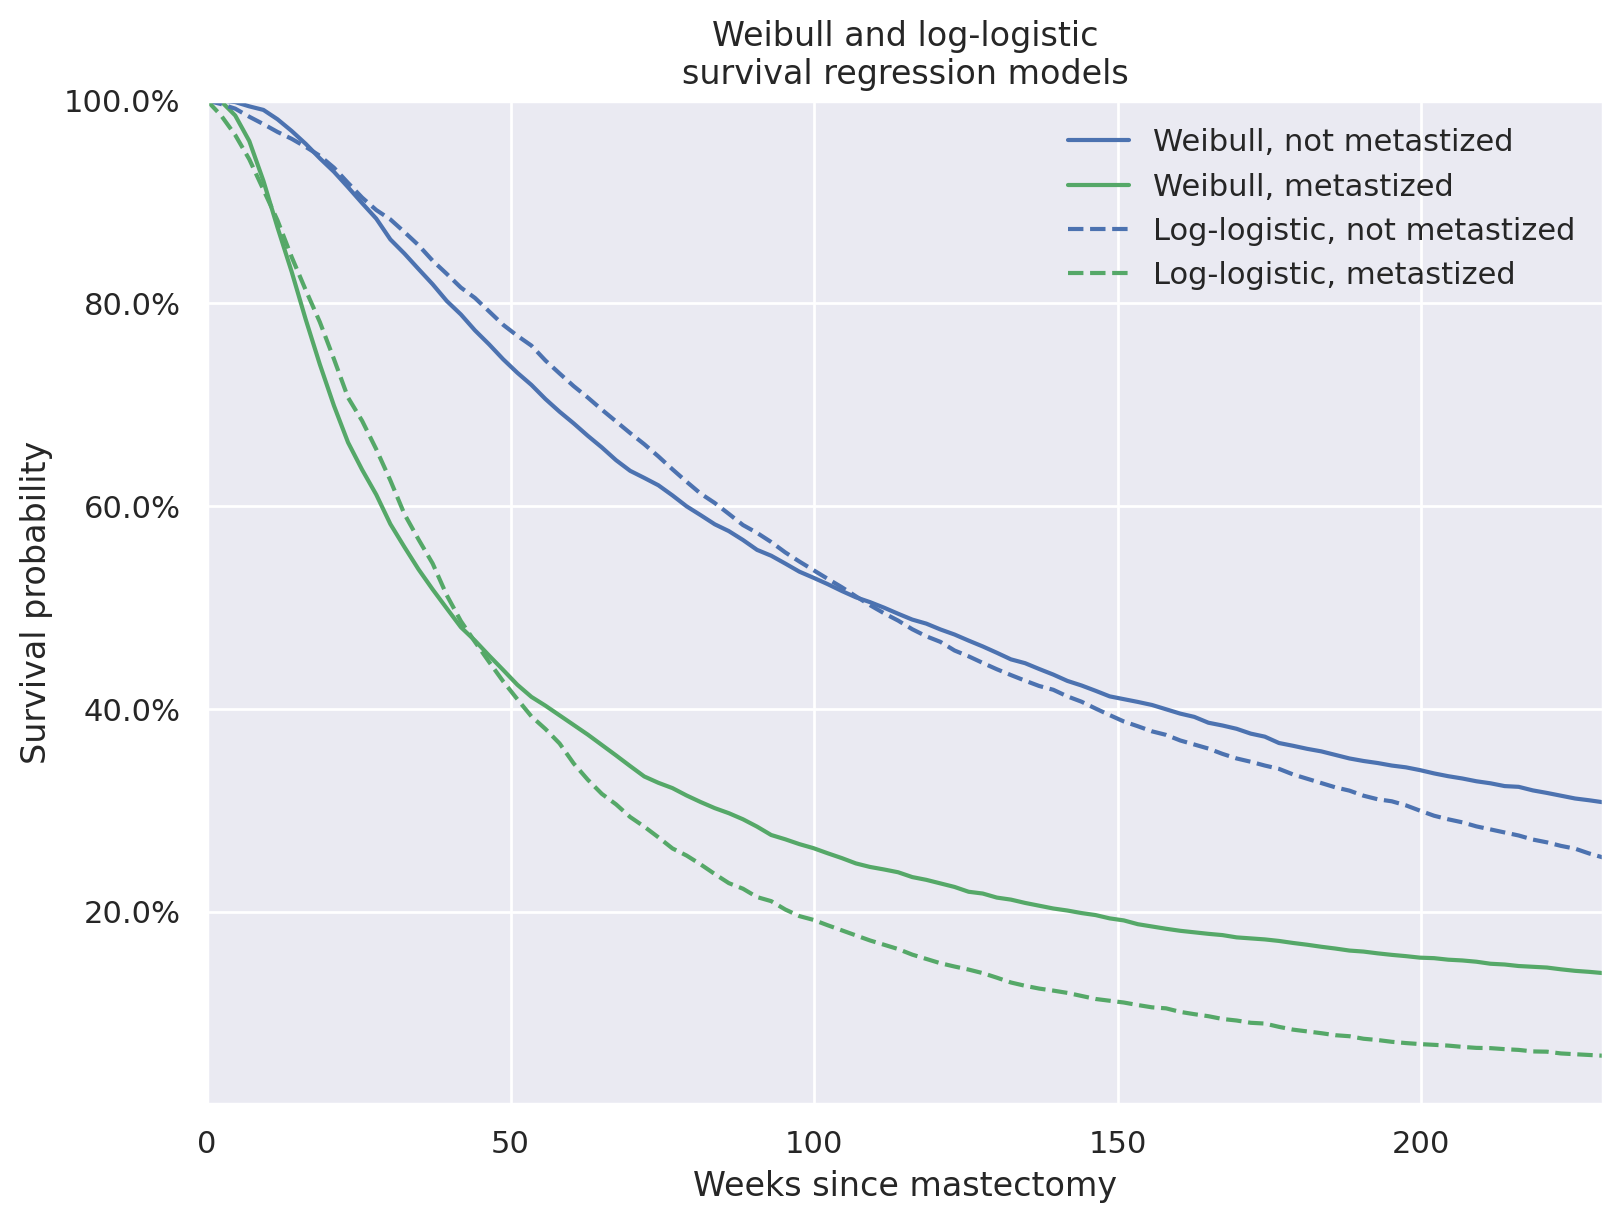

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(t_plot, weibull_pp_surv_mean[0], c=blue, label="Weibull, not metastized")
ax.plot(t_plot, weibull_pp_surv_mean[1], c=red, label="Weibull, metastized")

ax.plot(t_plot, log_logistic_pp_surv_mean[0], "--", c=blue, label="Log-logistic, not metastized")
ax.plot(t_plot, log_logistic_pp_surv_mean[1], "--", c=red, label="Log-logistic, metastized")

ax.set_xlim(0, 230)
ax.set_xlabel("Weeks since mastectomy")

ax.set_ylim(top=1)
ax.yaxis.set_major_formatter(pct_formatter)
ax.set_ylabel("Survival probability")

ax.legend(loc=1)
ax.set_title("Weibull and log-logistic\nsurvival regression models");

This post has been a short introduction to implementing parametric survival regression models in PyMC with a fairly simple data set.  The modular nature of probabilistic programming with PyMC should make it straightforward to generalize these techniques to more complex and interesting data set.

## Authors

- Originally authored as a blog post by [Austin Rochford](https://austinrochford.com/posts/2017-10-02-bayes-param-survival.html) on October 2, 2017.
- Updated by [George Ho](https://eigenfoo.xyz/) on July 18, 2018.
- Updated by @fonnesbeck on September 11, 2024.


In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Sep 12 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

pytensor   : 2.25.4
scipy      : 1.14.1
statsmodels: 0.14.2
arviz      : 0.19.0
seaborn    : 0.13.2
matplotlib : 3.9.2
pymc       : 5.16.2
numpy      : 1.26.4

Watermark: 2.4.3

